## Goal: estimate satisfaction function of a formula from instances of its satisfaction on individual runs at discrete parameter values

We use Gaussian Process Classification to estimate the satisfaction function.
Problem: the exact computation of the posterior probability is not possible --> use approximation from **Expectation Propagation (EP)** approach (high accuracy + computational efficiency) 

EP computes a Gaussian approximation to probabilistic models of the form
$ p(x|y) = p_0(x) \prod_i t_i (y_i,x_i)$   

$p_0(x)$ is a multivariate Gaussian distribution coupling all $x_i$ variables (*site variables*), $t_i$ can be general univariate distributions. Those models are calles *latent Gaussian models*: p0 represents prior distribution, with ti representing non-Gaussian observation likelihoods.  
EP approximation: likelihood terms replaced by univariate Gaussian terms $ q(x|y) = p_0(x) \prod_i \tilde{t}_i (y_i,x_i) $  



## Training dataset

Start with 1D training data. Invent random data from 0 to 15 with two Classes (0, 1). 

In C:\Users\klein\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\klein\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\klein\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\klein\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\klein\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

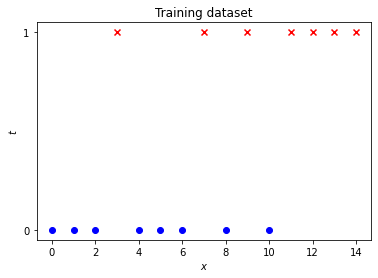

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math

from scipy.optimize import minimize
from scipy.stats import bernoulli
from scipy.special import expit as sigmoid

from sklearn.datasets import make_moons
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

%matplotlib inline


# training X, test X_test
X = np.arange(15).reshape(-1, 1)
X_test = np.arange(0, 18, 0.5).reshape(-1, 1)

# Bernoulli variables t = satisfaction 
t = np.array([0,0,0,1,0,0,0,1,0,1,0,1,1,1,1]).reshape(-1,1)

# plot data
plt.scatter(X[t == 0], t[t == 0], marker='o', c='blue')
plt.scatter(X[t == 1], t[t == 1], marker='x', c='red')
plt.title('Training dataset')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.yticks([0, 1])
plt.show()


# Kernel

We place a GP prior over the latent function $f(x)$ and then squash it to obtain the prior on $\pi(x) = p(y=1|x) = \sigma(f(x))$.  
We use the squared exponential covariance function $k(x,x')= \sigma^2 exp(- \frac{(x-x')^2}{2\lambda^2}) $.  
Squash it with: the logistic logit ($\lambda(z) = \frac{1}{1+ exp(-z)}$) and the probit transformation (cdf of normal distribution, $\Phi(z) = \int^z_{-\inf} \mathcal{N}(x|0,1)dx$).

We don't observe values of f itself, only onputs X and class labels y. We are only interested in $\pi$.

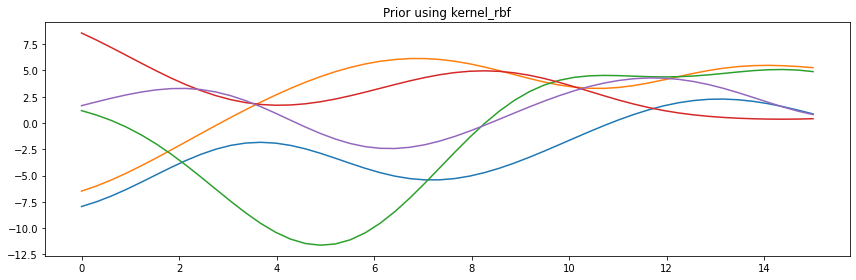

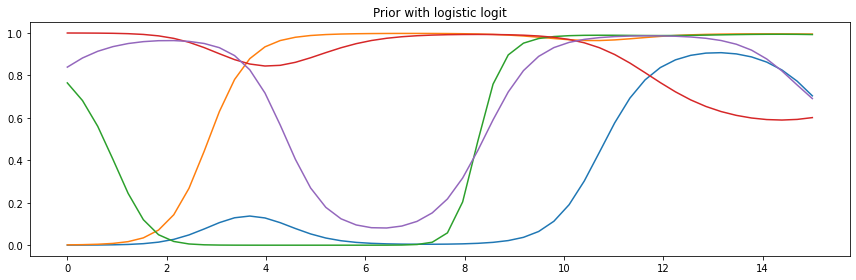

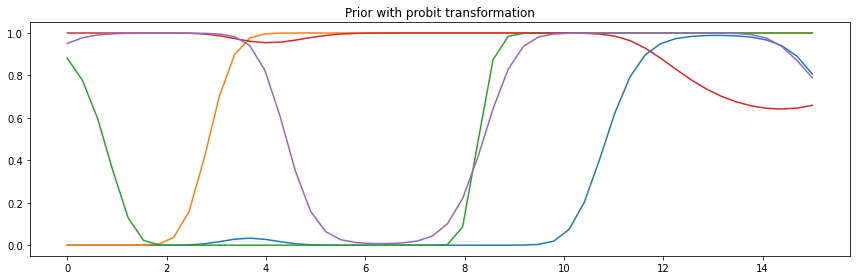

In [2]:
from scipy.stats import norm

def kernel_rbf(X1, X2, param):
    """
    Isotropic squared exponential kernel.

    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).
        param: Kernel parameters

    Returns:
        (m x n) matrix
    """

    sqdist = np.sum(X1 ** 2, 1).reshape(-1, 1) + np.sum(X2 ** 2, 1) - 2 * np.dot(X1, X2.T)
    return param[1] ** 2 * np.exp(-0.5 / param[0] ** 2 * sqdist)



# define all hyperparameters for all kernels
params = [3, 5]


# Test Data: N points from 0 to 15
N_s = 50
X_s = np.linspace(0, 15, N_s).reshape(-1,1)


# Prior using RBF 
plt.figure(figsize=(12, 4))

# compute mean and covariance
mu_prior = np.zeros(X_s.shape)
cov_prior = kernel_rbf(X_s, X_s, params)
# sample 5 normals from GP prior and plot
f_prior = np.random.multivariate_normal(mu_prior.ravel(), cov_prior, 5)
for sample in f_prior:
    plt.plot(X_s, sample, lw=1.5, ls='-')
plt.title(f'Prior using {kernel_rbf.__name__}')
plt.tight_layout()        
plt.show()



def log_logit(xs):
    return 1/(1+np.exp(-xs))

    
# Prior using RBF 
plt.figure(figsize=(12, 4))

# sample 5 normals from GP prior and plot
for sample in f_prior:
    plt.plot(X_s, log_logit(sample), lw=1.5, ls='-')
plt.title(f'Prior with logistic logit')
plt.tight_layout()        
plt.show()


plt.figure(figsize=(12, 4))
# sample 5 normals from GP prior and plot
for sample in f_prior:
    plt.plot(X_s, norm.cdf(sample), lw=1.5, ls='-')
plt.title(f'Prior with probit transformation')
plt.tight_layout()        
plt.show()

## Inference

2 steps:  
- compute distribution of latent variable corresponding to a test case: $p(f_*|X,y,x_*) = \int p(f_*|X,x_*,f) p(f|X,y) df$, where $p(f|X,y) = p(y|f)p(f|X)/p(y|X)$ is the posterior over the latent variables      

   
     
- use this distribution over latent $f_*$ to produce probabilistic prediction: $\overline{x}_* = p(y_*=1|X,y,x_*) = \int \sigma(f_*)p(f_*|X,y,x_*)df$   


Non-Gaussian likelihood makes integral intractable $\rightarrow$ approximate with Gaussian posterior $\Rightarrow$ Expectation Propagation algorithm

## Expectation Propagation

Posterior given by Bayes rule as product of normalization term, prior and likelihood: $p(f|X,y) = \frac{1}{Z} p(f|X) \prod p(y_i|f_i)$  
Prior $p(f|X)$ is Gaussian  
Likelihood factorizes over training cases  
Normalization term = marginal likelihood: $Z = p(y|X) = \int p(f|X) \prod p(y_i|f_i) df$  

Probit likelihood for binary classification: $p(y_i|f_i) = \Phi(f_iy_i)$  
$\rightarrow$ approximate by local likelihood approximation (unnormalized Gaussian function in latent variable $f_i$): $p(y_i|f_i) \approx t_i ( f_i|\tilde{Z}_i,\tilde{\mu}_i,\tilde{\sigma}_i^2) = \tilde{Z}_i \mathcal{N}(f_i|\tilde{\mu}_i,\tilde{\sigma}_i^2)$  

Product of independent local likelihoods $t_i$: $\prod t_i(f_i| \tilde{Z}_i,\tilde{\mu}_i,\tilde{\sigma}_i^2) = \mathcal{N}(\tilde{\mu},\tilde{\Sigma}) \prod \tilde{Z}_i$, where $\tilde{\mu}$ is vector of $\tilde{\mu}_i$ and $\tilde{\Sigma}$ is diagonal with $\tilde{\Sigma}_{ii} = \tilde{\sigma}^2_i$.  

Approximate posterior $p(f|X,y)$ by: $q(f|X,y) = \frac{1}{Z_{EP}} p(f|X) \prod t_i(f_i| \tilde{Z}_i,\tilde{\mu}_i,\tilde{\sigma}_i^2) = \mathcal{N}(\mu,\Sigma)$ [3.53] with $Z_{EP}=q(y|X)$ (approximation to normalizing term Z from previous eq.), $\mu=\Sigma\tilde{\Sigma}^{-1}\tilde{\mu}$ and $\Sigma=(K^{-1}+\tilde{\Sigma}^{-1})^{-1}$  

### How do we choose parameters of local approximating distributions $t_i$?  
Update individual $t_i$ approximations sequentially. Iterate these 4 steps until convergence:  
1. start from some current approximate posterior, from which we leave out current $t_i$ $\rightarrow$ marginal cavity distribution  
2. Combine cavity distribution with exact likelihood $p(y_i|f_i)$ to get desired (non-Gaussian) marginal  
3. Choose Gaussian approximation to marginal  
4. Compute the $t_i$ which makes posterior have the desired marginal from step 3   

Approximate posterior for $f_i$ contains 3 kinds of terms:  
1. Prior $p(f|X)$  
2. Local approximate likelihoods $t_j$ for all cases $j\neq i$  
3. Exact likelihood for case i, $p(y_i|f_i) = \Phi(y_if_i)$   

Goal: combine these sources of information and choose parameters of $t_i$ such that the marginal posterior is as accurate as possible. 

1. Combine prior and local likelihood approximations into cavity distribution: $q_{-i}(f_i) \propto \int p(f|X) \prod_{j\neq i} t_j (f_j|\tilde{Z}_j, \tilde{\mu}_j, \tilde{\sigma}_j^2) df_j$  
Either by explicitly multiplying out the terms, or by removing approximate likelihood i from the approximate posterior in 3.53.
2. Combine this with exact likelihood for case i. 

In [41]:
import numpy.matlib

# parameters from smoothed model checking
N = 7
numberOfTestPoints = 9
simulation_runs = 1
paramValueSet = np.array([2,3,5,7,8,10,11,12,14]).reshape(-1,1) # uncertain parameter that is varied = population size
datapoints = 9
paramValueOutputs = np.array([1,1,1,0,0,1,0,0,0]) # outputs of satisfaction (eig. #true/runs, aber hier nur 1 run)
data = trainingSet = [paramValueSet, paramValueOutputs] # set as training set for GP

params = [1.2, 0.5]
gauss_C = kernel_rbf(paramValueSet, paramValueSet, params)  # covariance training
gauss_LC_t = np.linalg.cholesky(gauss_C + 1e-4 * np.eye(datapoints))  # cholesky decomposition L
gauss_LC = gauss_LC_t.T  # transpose L' (or other way round?)
gauss_LC_diag = np.diagonal(gauss_LC)

logdet_LC = 2*np.sum(np.log(gauss_LC_diag))
logZprior = 0.5*logdet_LC

logZterms = np.zeros(datapoints)
logZloo = np.zeros(datapoints)
Term = np.zeros((datapoints, 2))
print(Term)
print(Term[:,1])

## compute marginal moments
tmp = np.multiply(numpy.matlib.repmat(Term[:,1], datapoints, 1), gauss_LC)
print(tmp)
A = np.matmul(gauss_LC_t, tmp) + np.multiply(np.eye(datapoints), 1)  # 1 in diagonal, other 0
print(A)

gauss_L = np.linalg.cholesky(A).T  # still 1 in diagonal, other 0 (unneccessary?)
print(gauss_L)

gauss_W = np.linalg.solve(gauss_L, gauss_LC_t)
print(gauss_W)

gauss_diagV = (np.multiply(gauss_W, gauss_W)).sum(axis=0) # sum each column of W^2
print(gauss_diagV)

tmp = np.matmul(gauss_W, Term[:,0])
gauss_m = np.matmul(gauss_W.T, tmp)  # 0 because Term is 0
print(gauss_m)
                
logdet = -2*np.sum(np.log(np.diag(gauss_L))) + 2*np.sum(np.log(np.diag(gauss_LC)))
print(logdet)

logdet += logdet_LC
print(logdet)

logZappx = 0.5 * (np.dot(gauss_m.T, Term[:,0]) + logdet)
print(logZappx)




[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[5.00099990e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+

In [51]:
## stuff related to likelihood

gauss_LikPar_p = paramValueOutputs
gauss_LikPar_q = 1 - paramValueOutputs
nodes = 96
gauss_xGauss = np.zeros((nodes, 1))
gauss_wGauss = np.zeros((nodes, 1))

#gausshermite(nodes, gauss_xGauss, gauss_wGauss) -> n, x, w
#https://indico.frib.msu.edu/event/15/attachments/40/157/Gaussian_Quadrature_Numerical_Recipes.pdf
x0 = gauss_xGauss
w0 = gauss_wGauss
m = int((nodes+1)/2)
z,pp,p1,p2,p3 = 0,0,0,0,0
for i in range(m):
    if i==0:
        z = np.sqrt(2*nodes+1) - 1.85575 * ((2*nodes+1)**-0.166667)
    elif i==1:
        z = z - 1.14 * nodes**0.426 / z
    elif i==2:
        z = 1.86 * z - 0.86 * x0[0]
    elif i==3:
        z = 1.91 * z - 0.91 * x0[1]
    else:
        z = 2.0 * z - x0[i - 2]
    
    for its in range(10):
        p1 = 1/np.sqrt(np.sqrt(np.pi))
        p2 = 0
        for j in range(1,nodes+1):
            p3=p2
            p2=p1
            a = z*np.sqrt(2/j)*p2
            b = np.sqrt((j-1)/j)*p3
            p1=a-b
        pp=np.sqrt(2*nodes)*p2
        z1=z
        z=z1-p1/pp
        if np.abs(z-z1)<2.2204e-16:
            break
    
    x0[i] = z
    x0[nodes-1-i] = -z
    w0[i] = 2/(pp*pp)
    w0[nodes-1-i] = w0[i]
    
w0 = np.divide(w0, np.sqrt(np.pi))
x0 = np.multiply(x0, np.sqrt(2))
x0 = np.sort(x0, axis=None)

gauss_xGauss=x0
gauss_wGauss=w0
       
print(gauss_xGauss)

gauss_logwGauss = np.log(gauss_wGauss)
#print(gauss_logwGauss)

[-18.54900896 -17.71900805 -17.03392905 -16.42414008 -15.86305703
 -15.3369878  -14.83772298 -14.3598556  -13.89958774 -13.45412323
 -13.02132803 -12.59952643 -12.1873718  -11.78376099 -11.38777557
 -10.99864015 -10.61569213 -10.23835931  -9.86614278  -9.49860392
  -9.13535408  -8.77604655  -8.42036997  -8.06804314  -7.71881063
  -7.37243927  -7.02871513  -6.68744106  -6.34843453  -6.01152588
  -5.67655674  -5.34337869  -5.01185214  -4.68184527  -4.35323316
  -4.02589701  -3.69972343  -3.37460381  -3.05043374  -2.72711256
  -2.4045428   -2.08262983  -1.76128143  -1.44040739  -1.11991923
  -0.7997298   -0.47975303  -0.15990355   0.15990355   0.47975303
   0.7997298    1.11991923   1.44040739   1.76128143   2.08262983
   2.4045428    2.72711256   3.05043374   3.37460381   3.69972343
   4.02589701   4.35323316   4.68184527   5.01185214   5.34337869
   5.67655674   6.01152588   6.34843453   6.68744106   7.02871513
   7.37243927   7.71881063   8.06804314   8.42036997   8.77604655
   9.13535

In [55]:
## cycle control -> optimize until convergence
MaxIter=1000
tol=1e-6
logZold=0
logZ = 2*tol
steps=0
logZappx=0
eps_damp=0.5

while (np.abs(logZ-logZold)>0) and (steps<MaxIter):
    steps += 1
    logZold = logZ
    
    # compute cavities cavGauss = ComputeCavities(gauss, Term.neg())
    C = gauss_diagV
    s = np.divide(np.ones(len(C)), (1 + np.multiply(-Term[:,1], C)))
    cav_diagV = np.multiply(s, C)
    cav_m = np.multiply(s, (gauss_m + np.multiply(-Term[:,0], C)))
    
    # ep update
    update = ep_update(cav_diagV, cav_m, Term, eps_damp, null, gauss_LikPar_p,
                      gauss_LikPar_q, gauss_xGauss, gauss_logwGauss)
    
    
    
def ep_update(cav_diagV, cav_m, Term, eps_damp, null, gauss_LikPar_p,
                      gauss_LikPar_q, gauss_xGauss, gauss_logwGauss):
    
    Cumul = np.zeros((datapoints, 2))
    logZ = GaussHermiteNQ(LikPar_p, LikPar_q, cavGauss.m, cavGauss.diagV, xGauss, wGauss, Cumul);

[0. 0. 0. 0. 0. 0. 0. 0. 0.]
